In [32]:
import os
import numpy
import subprocess
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot
import tqdm
import time

In [33]:
# remote mount the GRAMS directory on local machine (requires SSHFS)
host = "ub"
remote_path = "/home/ub/WinDriver/wizard/GRAMS_project_am "
GRAMSdir = os.path.expanduser("~/remote_mount")
os.makedirs(GRAMSdir, exist_ok=True) # make a mount point in your home directory if it doesn't already exist

# mount and unmount commands
mount = f"sshfs {host}:{remote_path} {GRAMSdir} -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa"
unmount = f"umount {GRAMSdir}"

try:
    # make sure the directory is not currently mounted, then mount
    subprocess.run(unmount, shell=True, check=True)
    subprocess.run(mount, shell=True, check=True)
except:
    # otherwise just directly mount
    subprocess.run(mount, shell=True, check=True)

umount(/Users/svan/remote_mount): Resource busy -- try 'diskutil unmount'
mount_macfuse: mount point /Users/svan/remote_mount is itself on a macFUSE volume


CalledProcessError: Command 'sshfs ub:/home/ub/WinDriver/wizard/GRAMS_project_am  /Users/svan/remote_mount -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa' returned non-zero exit status 1.

In [22]:
# alternatively, you can set this directory manually:
## GRAMSdir = "/path/to/decoded/root/files"
## GRAMSdir = os.path.expanduser("~/Software/GRAMS")

In [98]:
# load file_id CSV into dataframe
file_id = f"{GRAMSdir}/readout_test_51624.csv"
csv = pd.read_csv(file_id)

# extract all ADC trees as arrays and store in np_dict
# filenames = csv['File ID'].tolist()
filenames = [450]
df_dict = {};

for filename in tqdm.tqdm(filenames, desc=f'extracting ADC data...', total=len(filenames)):
    file = uproot.open(f"{GRAMSdir}/outfile_{filename}.root")
    tree = file["adc_tree"]
    df_dict[f'{filename}']=tree.arrays(library="pd")

extracting ADC data...: 100%|█████████████████████| 1/1 [00:02<00:00,  2.85s/it]


## Waveform Plotter

In [ ]:
for filename in file_list:
    # extract df for 
    df = df_dict[f'{filename}']

    # find FEM for run
    fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]

    # slice dataframe for FEM and desired channel and event
    mask = df[(df['fem_id'] == fem_id) & (df['event_id'] == event_id) & (df['channel_id'] == active_ch)]

In [97]:
def waveform_plotter(file_list, active_ch, event_id, overlay=1, average=0):
# inputs: list of files you would like plotted, channel number of interest, event number of interest, and overlay on or off 

    if overlay == 1:
        figure = plt.figure(figsize=[9,6])
        
    for filename in file_list:
        # extract df for 
        df = df_dict[f'{filename}']

        # find FEM for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]

        # slice dataframe for FEM and desired channel and event
        mask = df[(df['fem_id'] == fem_id) & (df['event_id'] == event_id) & (df['channel_id'] == active_ch)]
    
        # create time axis (2 MHz sampling rate -> 0.5 us steps)
        time = 0.5*(mask.index - mask.index.min())

        # plot
        if average == 1:
            # if average is enabled, only plot averaged waveform
            average += mask['adc_count'].values
        elif average == 0 and overlay == 1:
            # if overlay is enabled, plot on the same figure
            plt.plot(time, mask['adc_count'], label=f'Run {filename}')
        else:
            # if overlay is disabled, new figure for each run
            plt.figure()
            plt.plot(time, mask['adc_count'])
            plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}, Run {filename}')
            plt.xlabel('Time (us)')
            plt.ylabel('ADC Counts')
            plt.xlim(time.min(), time.max())
            plt.ylim(0, 4095)
            plt.grid(True)
            plt.show()
        
    # show legend if overlay is enabled
    if overlay == 1:
        plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        plt.ylim(0, 4095)
        plt.grid(True)
        plt.legend()
        plt.show()
        
    return

IndentationError: expected an indented block after 'if' statement on line 21 (66084871.py, line 23)

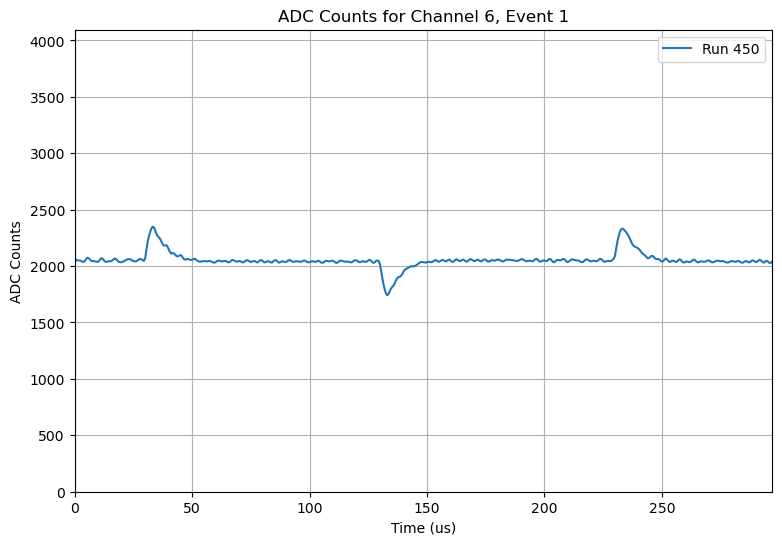

In [99]:
file_list = [450]

waveform_plotter(file_list, active_ch=6, event_id=1, overlay=1)

In [ ]:
# average plotter

## Everything Else

In [91]:
# INPUTS/CONFIG

active_ch = [6, 8, 12, 14, 16, 20, 22, 24] # channel numbers of interest
fem_id = 14 # FEM number (usually slot 11 or 12)
file_id = f"{GRAMSdir}/ampvQ_51624.csv" # path to .csv with run IDs, run input pulse heights in mV, and ADC ch. no's

overlay = 1 # set to 0 for individual plots, 1 for overlaid plots

### ADC Amplitude vs. Input Charge Plotter

In [92]:
# read file_id into dataframe
csv = pd.read_csv(file_id)

#initialize figure
#if overlay == 1:
#    ampQ, ax = plt.subplots()

Q = dict()
peaks = dict()
for ch in active_ch:
    # extract file_list and pulse heights for given channel
    slice_ch = csv[csv['ADC Ch.'].isin([ch])]
    file_list = slice_ch['File ID'].tolist()
    mV = slice_ch['Input (mVpp)'].tolist()
    
    # convert to charge
    Vdiv = (1/11) # preamp voltage divider
    Cin = 1 # preamp input capacitance, in pF
    Q[ch] = (np.array(mV) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC
    
    peaks[ch] = []
    for filename in tqdm.tqdm(file_list, desc=f'analyzing channel {ch}', total=len(file_list)):
        df = df_dict[f'{filename}']
        
        # slice dataframe for desired FEM and channel, find max height for each event
        slice = df[(df['fem_id'] == fem_id) & (df['channel_id'] == ch)]
        grouped = slice.groupby('event_id')
        max_counts = grouped['adc_count'].max()
        peaks[ch].append(max_counts.mean())
    
#     # standard deviation
#     std_dev = np.std(peaks)

analyzing channel 24: 100%|████████████████████| 12/12 [00:00<00:00, 148.44it/s]


In [93]:
def plot_counts_vs_inputQ(Q, peaks, active_ch, overlay=1):
    # if overlay is enabled, plot on the same figure
    if overlay:
        figure = plt.figure(figsize=[9,6])
        [plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}') for c in active_ch]
        plt.title(f'ADC Amplitude vs. Input Charge')
        plt.xlabel('Input Charge (fC)', fontsize=20)
        plt.ylabel('Counts')
        plt.ylim(plt.ylim()[0], 4150)
        plt.grid(True)
        plt.legend(fontsize=22)
        plt.show()
    else:
        for c in active_ch:
            plt.figure(figsize=[9,6])
            plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}')
            plt.title(f'ADC Amplitude vs. Input Charge')
            plt.xlabel('Input Charge (fC)', fontsize=20)
            plt.ylabel('Counts')
            plt.ylim(plt.ylim()[0], 4150)
            plt.grid(True)
            plt.legend(fontsize=22)
            plt.show()
            
    return figure

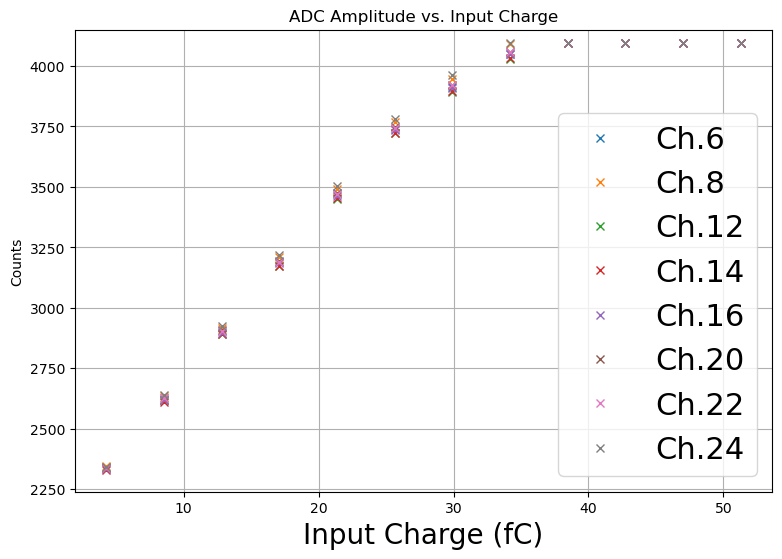

In [95]:
my_figure = plot_counts_vs_inputQ(Q, peaks, active_ch, overlay=1)

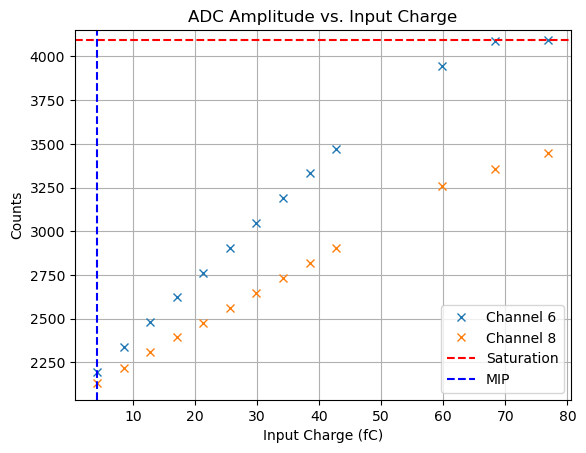

In [105]:
# add noise, saturation, and MIP bound to plot (only if they don't already exist)
if not any(line.get_label() == 'Saturation' for line in ax.get_lines()):
    ax.axhline(y=4095, color='r', linestyle='--', label='Saturation')
if not any(line.get_label() == 'MIP' for line in ax.get_lines()):
    ax.axvline(x=4.27, color='b', linestyle='--', label='MIP')
# if not any(line.get_label() == 'Noise' for line in ax.get_lines()):
#     ax.axhline(y=4095, color='r', linestyle='--', label='Noise')

ax.legend()
ampQ

### Linearity